<a href="https://colab.research.google.com/github/jonathanahc/PLN_Practicas/blob/main/Clasificaci%C3%B3n_de_textos_Jonathan_Herrera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score)

# ***Importing Dataset***

In [7]:
df = pd.read_csv('/content/drive/MyDrive/PLN/IMDB Reviews(in).csv', engine = 'python', encoding = 'utf-8')

In [8]:
df.head()

,review,sentimento
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# ***Exploratory Data Analysis (EDA)***

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      50000 non-null  object
 1   sentimento  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [10]:
df.describe()

,sentimento
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [11]:
df.isna().sum()

,0
review,0
sentimento,0


In [12]:
df.shape

(50000, 2)

<Axes: xlabel='sentimento'>

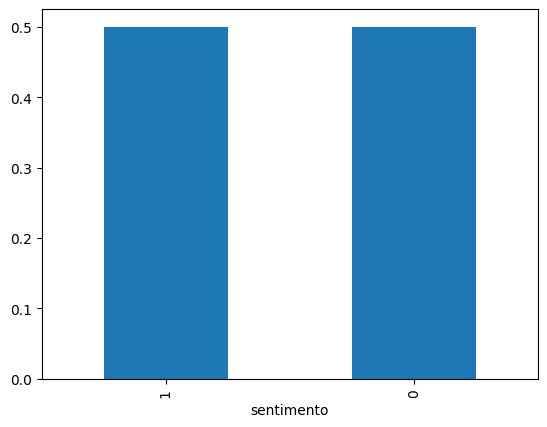

In [13]:
df['sentimento'].value_counts(normalize = True).plot.bar()

# ***Text Preprocessing***

In [14]:
def clear(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = text.split()
    return text

df['review'] = df['review'].apply(clear)

In [15]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [16]:
text = list(df['review'])

In [17]:
lemmatizer = WordNetLemmatizer()
corpus = []

In [18]:
for i in range(len(text)):
  l = text[i]
  l = [word for word in l if word not in stopwords.words('english')]
  l = [lemmatizer.lemmatize(word) for word in l]
  l = ' '.join(l)
  corpus.append(l)

df['review'] = corpus

In [19]:
df.head()

,review,sentimento
0,one reviewer mentioned watching 1 oz episode y...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1


# ***Train-test-split***

In [20]:
X = df['review']
y = df['sentimento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Training Data :', X_train.shape)
print('Testing Data : ', X_test.shape)

Training Data : (40000,)
Testing Data :  (10000,)


# ***Model Training and Evaluation***

In [24]:
def entrenar_y_evaluar(modelo, X_train_vec, X_test_vec, y_train, y_test, nombre_modelo, metodo):
    modelo.fit(X_train_vec, y_train)
    y_pred = modelo.predict(X_test_vec)

    # Reporte por clase
    reporte = classification_report(y_test, y_pred, output_dict=True)

    # Métricas globales
    accuracy = accuracy_score(y_test, y_pred)

    # Para AUC-ROC
    try:
        if hasattr(modelo, "predict_proba"):
            y_prob = modelo.predict_proba(X_test_vec)[:,1]
        else:
            y_prob = modelo.decision_function(X_test_vec)
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0","Clase 1"], yticklabels=["Clase 0","Clase 1"])
    plt.title(f"Matriz de Confusión - {nombre_modelo} ({metodo})")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.savefig(f"cm_{nombre_modelo}_{metodo}.png")
    plt.close()

    return {
        "Clase 0 Precision": reporte['0']['precision'],
        "Clase 0 Recall": reporte['0']['recall'],
        "Clase 0 F1-Score": reporte['0']['f1-score'],
        "Clase 1 Precision": reporte['1']['precision'],
        "Clase 1 Recall": reporte['1']['recall'],
        "Clase 1 F1-Score": reporte['1']['f1-score'],
        "Accuracy": accuracy,
        "AUC-ROC": auc
    }

=== Bag of Words Confusion Matrices ===


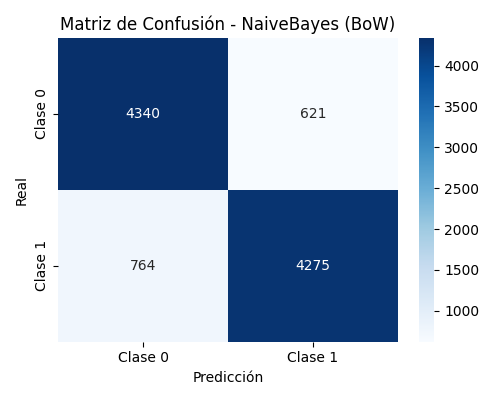

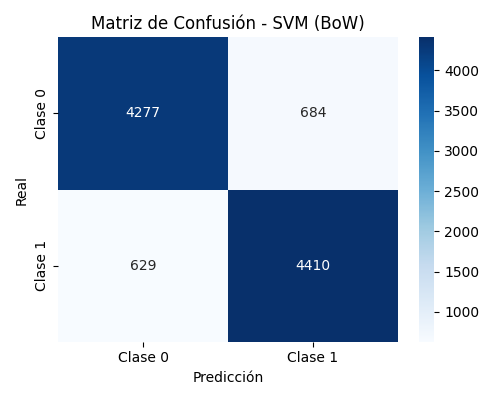

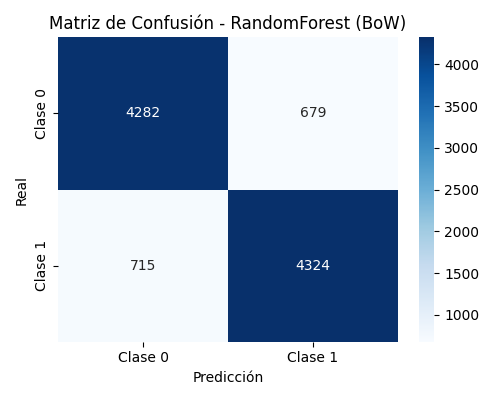

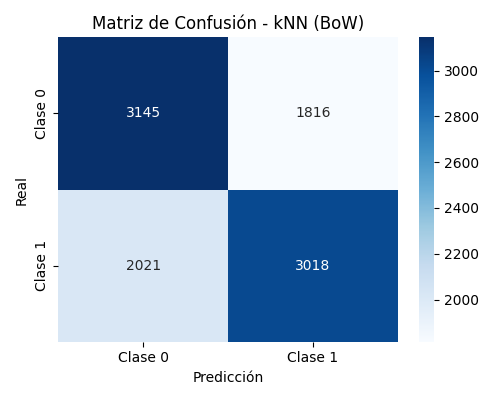

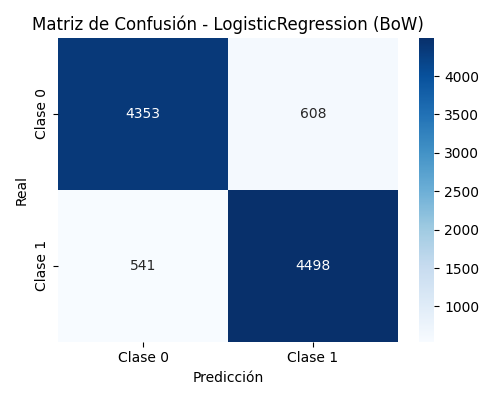


=== TF-IDF Confusion Matrices ===


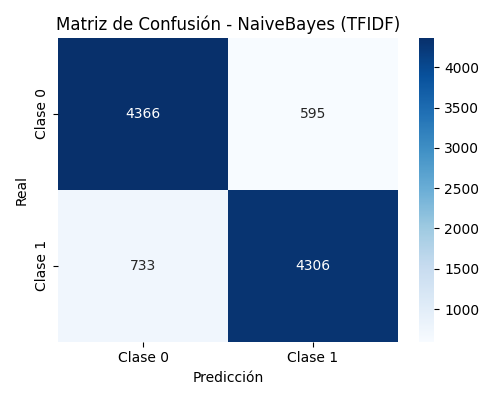

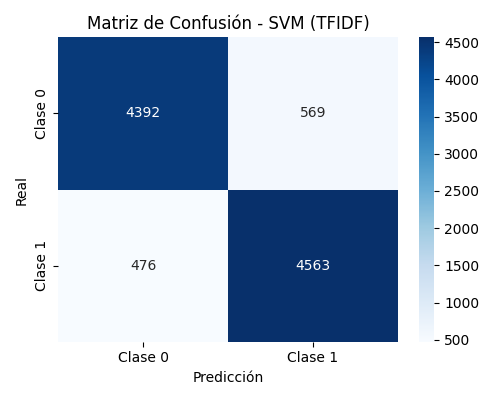

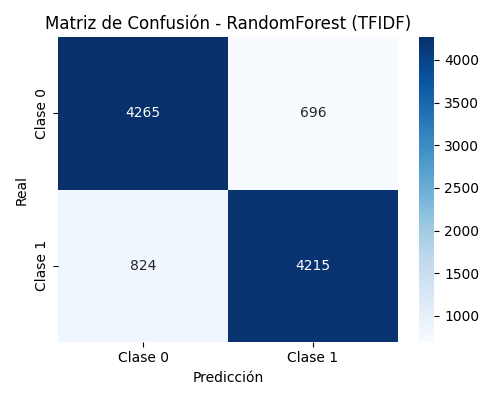

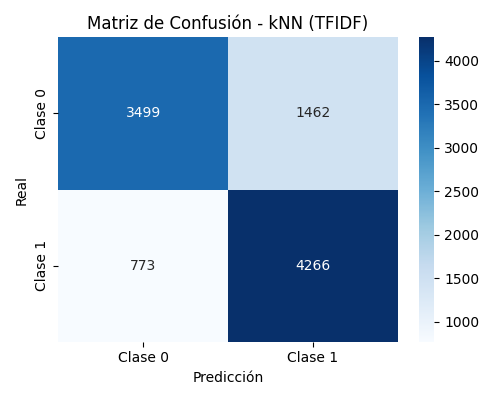

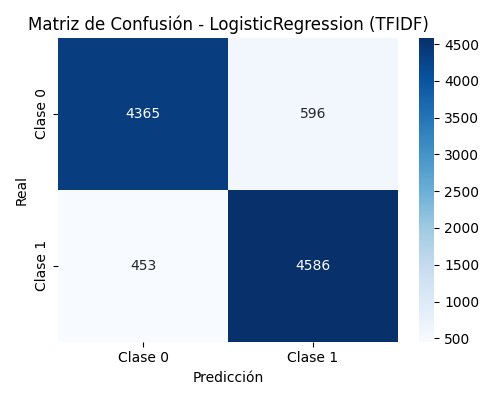

In [29]:
from IPython.display import Image, display

print("=== Bag of Words Confusion Matrices ===")
display(Image(filename="cm_NaiveBayes_BoW.png"))
display(Image(filename="cm_SVM_BoW.png"))
display(Image(filename="cm_RandomForest_BoW.png"))
display(Image(filename="cm_kNN_BoW.png"))
display(Image(filename="cm_LogisticRegression_BoW.png"))

print("\n=== TF-IDF Confusion Matrices ===")
display(Image(filename="cm_NaiveBayes_TFIDF.png"))
display(Image(filename="cm_SVM_TFIDF.png"))
display(Image(filename="cm_RandomForest_TFIDF.png"))
display(Image(filename="cm_kNN_TFIDF.png"))
display(Image(filename="cm_LogisticRegression_TFIDF.png"))

In [25]:
def correr_experimento(vectorizador, metodo):
    # Vectorización
    X_train_vec = vectorizador.fit_transform(X_train)
    X_test_vec = vectorizador.transform(X_test)

    # Modelos
    modelos = {
        "NaiveBayes": MultinomialNB(),
        "SVM": LinearSVC(),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "kNN": KNeighborsClassifier(n_neighbors=5),
        "LogisticRegression": LogisticRegression(max_iter=1000)
    }

    resultados = {}
    for nombre, modelo in modelos.items():
        resultados[nombre] = entrenar_y_evaluar(modelo, X_train_vec, X_test_vec, y_train, y_test, nombre, metodo)

    return pd.DataFrame(resultados).T


In [28]:
print("=== Bag of Words ===")
tabla_bow = correr_experimento(CountVectorizer(), "BoW")
print(tabla_bow)

print("\n=== TF-IDF ===")
tabla_tfidf = correr_experimento(TfidfVectorizer(), "TFIDF")
print(tabla_tfidf)

=== Bag of Words ===


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                    Clase 0 Precision  Clase 0 Recall  Clase 0 F1-Score  \
NaiveBayes                   0.850313        0.874824          0.862394   
SVM                          0.871790        0.862125          0.866930   
RandomForest                 0.856914        0.863132          0.860012   
kNN                          0.608788        0.633945          0.621112   
LogisticRegression           0.889456        0.877444          0.883409   

                    Clase 1 Precision  Clase 1 Recall  Clase 1 F1-Score  \
NaiveBayes                   0.873162        0.848383          0.860594   
SVM                          0.865724        0.875174          0.870423   
RandomForest                 0.864281        0.858107          0.861183   
kNN                          0.624328        0.598928          0.611364   
LogisticRegression           0.880924        0.892637          0.886742   

                    Accuracy   AUC-ROC  
NaiveBayes            0.8615  0.925887  
SVM             